In [1]:
import numpy as np
import scipy as sp

#import h5py
#import natsort
#from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
#from functools import partial

from jax import jit

import jax
import jax.numpy as jnp
import time

import jax.scipy.optimize

# this is the package to solve
import FWI.jax_fd as jax_fd
import FWI.near_field as near_field

In [43]:
# size of the domain in x and y
ax = 1.0
ay = 1.0

# number of discretization points per dimension
nxi = 80
nyi = nxi

# PML
npml = 20
sigmaMax = 80

nx = nxi + 2*npml
ny = nx

#omega = 2*jnp.pi*(nyi//10)
omega = 2*jnp.pi*10


order = 2

# grid spacing
hx = 1/(nxi-1)

sampling_radius = 1.0
n_angles = nxi


In [44]:
# initialize the parameters
params_nf = near_field.init_params_near_field_plane(ax, ay, nxi, nyi,npml,
                                         sampling_radius,
                                         n_angles, omega, sigmaMax)

In [45]:
# definition of the perturbation by the lense
@jit
def perturbation(x,y):
    #return (0.2*sp.stats.norm.pdf(x,0.1,5*hx)*sp.stats.norm.pdf(y,0.1,5*hx))
    return    1.0*jnp.exp(-500*(jnp.square(x+0.1) + jnp.square(y+0.2)))\
            + 1.0*jnp.exp(-500*(jnp.square(x-0.1) + jnp.square(y-0.1)))\
            + 1.0*jnp.exp(-500*(jnp.square(x-0.15) + jnp.square(y+0.3)))

In [46]:
# we sample the perturbation
eta = perturbation(params_nf.fd_params.Xi, params_nf.fd_params.Yi) 
#m = 1 + eta
eta_vect = np.reshape(eta, (-1,))
#m_vect = np.reshape(m, (-1,))

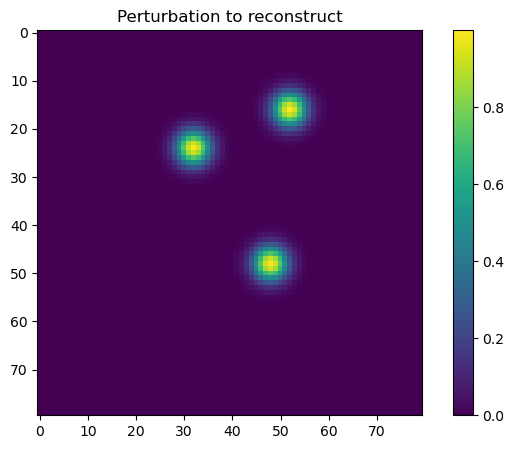

In [131]:
plt.figure(figsize=(8,5))
plt.imshow(jnp.real(eta_vect).reshape((nxi,nyi)))
#plt.xticks([])
#plt.yticks([])
plt.title('Perturbation to reconstruct', color='black')
plt.colorbar()
plt.show()

In [48]:
eta_ext = near_field.ExtendModel(eta, nxi, nyi, npml)

In [49]:
tol = 1e-02
#H = jax_fd.HelmholtzMatrix(m_ext, params_nf.fd_params.nx, params_nf.fd_params.ny,
#                           params_nf.fd_params.npml, params_nf.fd_params.h,
#                           params_nf.fd_params.SigmaMax, order, omega, 'compact_explicit')
H = jax_fd.HelmholtzMatrix_off_diag(params_nf.fd_params.nx, params_nf.fd_params.ny,
                                    params_nf.fd_params.npml, params_nf.fd_params.h,
                                    params_nf.fd_params.SigmaMax, order, omega)

In [54]:
near_field_ = near_field.NearField(H, omega, params_nf, tol)
#near_field_jit = jit(near_field_())

In [55]:
#field = near_field_jit(eta_ext)
field = near_field_()(eta_ext)

In [56]:
Lambda = near_field.smoothing_solution(field, params_nf, n_angles, sampling_radius)

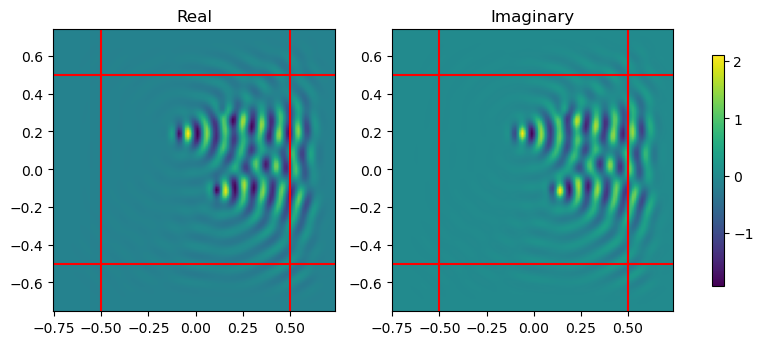

In [57]:
near_field.DisplayField(field[:,0],params_nf.fd_params.x,params_nf.fd_params.y, npml)

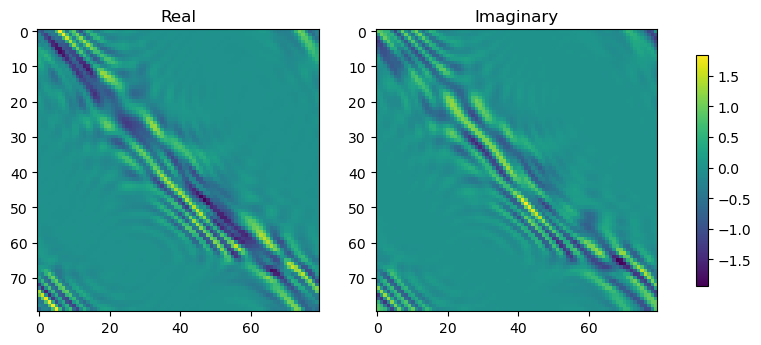

In [58]:
near_field.DisplayField(Lambda, params_nf.fd_params.xi,params_nf.fd_params.yi)

In [135]:
u_i_plot = params_nf.u_i.reshape((120,120,80))

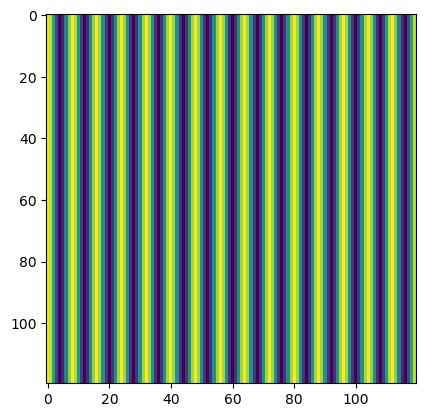

In [145]:
plt.imshow(jnp.real(u_i_plot[:,:,0]))

# TODO: Check that the ordering of u_i is the same as in MATLAB code that produces this signal

## Optimization process

In [15]:
projection_mat = near_field.get_projection_mat(params_nf, n_angles, sampling_radius)

In [16]:
projection_mat.shape

(80, 14400)

In [17]:
eta_0 = jnp.real(0*eta_vect)

In [18]:
misfit_ = near_field.MisFit(H, omega, params_nf, tol, Lambda, projection_mat)
#misfit_jit = jit(misfit_())

In [18]:
loss_at_0 = misfit_()(eta_0)
#loss_at_0_jit = misfit_jit(eta_0)

In [19]:
grad_loss_at_0 = jax.grad(misfit_())(eta_0)

In [21]:
#grad_misfit_ = near_field.GradMisFit(H, omega, params_nf, tol, Lambda, projection_mat)
#grad_misfit_jit = jit(grad_misfit_())

In [20]:
#opt_result = sp.optimize.minimize(fun=misfit_(), x0=eta_0, method='bfgs', jac=True)#, options={'disp': True}, 'maxiter': 20})
opt_result = jax.scipy.optimize.minimize(misfit_(), x0=eta_0, method='BFGS')

opt_eta_vect = opt_result.x

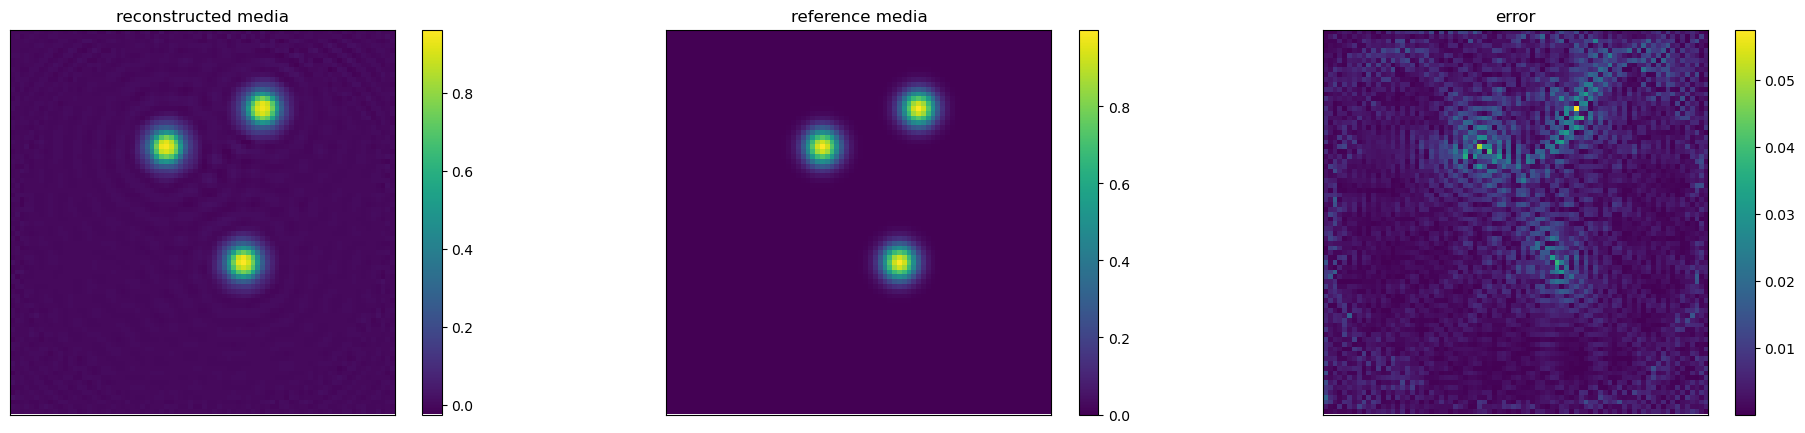

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,5))


im1 = ax1.imshow(jnp.real(opt_eta_vect).reshape((nxi,nyi)))
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('reconstructed media', color='black')
fig.colorbar(im1, ax=ax1)

im2 =ax2.imshow(jnp.real(eta_vect).reshape((nxi,nyi)))
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('reference media', color='black')
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(jnp.abs(eta_vect - opt_eta_vect).reshape((nxi,nyi)))
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('error', color='black')
fig.colorbar(im3, ax=ax3)

plt.show()